# Tarea 2 - Taller de Deep Learning

**Fecha de entrega: 16/11/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su capacidad para aplicar modelos de redes neuronales recurrentes (RNN/LSTM/GRU) en un problema de clasificación de secuencias. En particular, vamos a evaluar la performance de sus modelos en la clasificación de ritmos cardíacos usando datos de electrocardiograma (ECG).

**Dataset**

El dataset a ser utilizado es el [Heartbeat Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). Este dataset contiene señales de ECG segmentadas, donde cada segmento corresponde a un latido del corazón. Cada segmento ya está preprocesado y categorizado en una de las siguientes clases:

- **N**: Normal (0)
- **S**: Arritmia supraventricular (1)
- **V**: Arritmia ventricular (2)
- **F**: Latido fusionado (3)
- **Q**: Latido desconocido (4)

Los archivos del dataset que deben utilizar son:

- **mitbih_train.csv**: Datos de entrenamiento.
- **mitbih_test.csv**: Datos de prueba.

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema, así como las técnicas y herramientas que quieran usar. Se recomienda el uso de Google Colab para simplificar el acceso a recursos de GPU, aunque pueden trabajar en sus propias máquinas si lo prefieren. La entrega debe realizarse en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar modelos pre-entrenados; cada modelo debe ser implementado desde cero.
- Deben utilizar al menos un modelo basado en RNN (por ejemplo, LSTM o GRU).
- Es necesario realizar un **análisis exploratorio de los datos**, que incluya una descripción de las señales ECG, el balanceo de clases y cualquier limpieza o transformación necesaria de los datos.
- Las decisiones sobre el preprocesamiento de las señales (como normalización, segmentación, etc.) deben estar fundamentadas en una exploración inicial del dataset y explicadas en el notebook.

**Reporte**

Se requiere que reporten las siguientes métricas: accuracy, precision, recall y F1-score para la evaluación del modelo. Además, se espera ver una evolución clara del modelo durante el entrenamiento, que incluya logs y gráficas de las métricas tanto para los datos de entrenamiento como de validación.

**Evidencia de Experimentos**

Deben proporcionar evidencia de la ejecución de experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:

- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [2]:
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
from collections import Counter

from torchinfo import summary
import utils

In [4]:
import sys

DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [5]:
BATCH_SIZE = 256  # tamaño del batch

## Cargamos datos + EDA


In [6]:
TRAIN_DATA_PATH = "mitbih_train.csv"
TEST_DATA_PATH = "mitbih_test.csv"

In [7]:
df_train = pd.read_csv(TRAIN_DATA_PATH, header=None)
df_test = pd.read_csv(TEST_DATA_PATH, header=None)

df_train = df_train.dropna()
df_test = df_test.dropna()

# Concatenamos los datos de entrenamiento y test
df = pd.concat([df_train, df_test], axis=0)

In [8]:
print(f"El dataset cuenta con {df.iloc[:,-1].nunique()} clases distintas")

El dataset cuenta con 5 clases distintas


In [9]:
TARGET_NAMES = [
    "Normal",
    "Arritmia supraventricular",
    "Arritmia ventricular",
    "Latido fusionado",
    "Latido desconocido",
]


187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64


<Axes: title={'center': 'Número de muestras por clase'}, xlabel='187'>

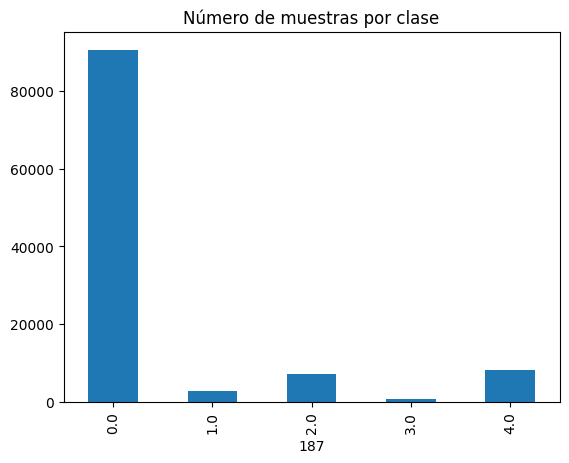

In [10]:
class_count = df.iloc[:, -1].value_counts()
print(class_count)

class_count.sort_index().plot(kind="bar", title="Número de muestras por clase")

In [11]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df.iloc[:, -1]),
    y=df.iloc[:, -1]
)

# Convert to a dictionary for easier use
class_weights_dict = dict(zip(np.unique(df.iloc[:, -1]), class_weights))
print("Class weights:")
print(class_weights_dict)

# Convert to tensor for use with PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print("\nClass weights tensor:")
print(class_weights_tensor)

Class weights:
{np.float64(0.0): np.float64(0.2416319862234929), np.float64(1.0): np.float64(7.876646275638719), np.float64(2.0): np.float64(3.0250414593698176), np.float64(3.0): np.float64(27.259277708592776), np.float64(4.0): np.float64(2.722875979599453)}

Class weights tensor:
tensor([ 0.2416,  7.8766,  3.0250, 27.2593,  2.7229], device='cuda:0')


Creamos la clase MITBIHDataSet

In [12]:
class MITBIHDataSet(Dataset):
    def __init__(self, df_features, df_target, num_classes):
        self.x_df = df_features.values
        self.y_df = df_target.values
        self.num_classes = num_classes

    def __len__(self):
        return len(self.x_df)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_df[idx], dtype=torch.float32)
        y = torch.tensor(self.y_df[idx], dtype=torch.long)
        return x, y

In [13]:
X_train = df_train.iloc[:, :-1]  # Extraemos las características
y_train = df_train.iloc[:, -1]  # Extraemos las etiquetas

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [14]:
SEED = 23

In [15]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

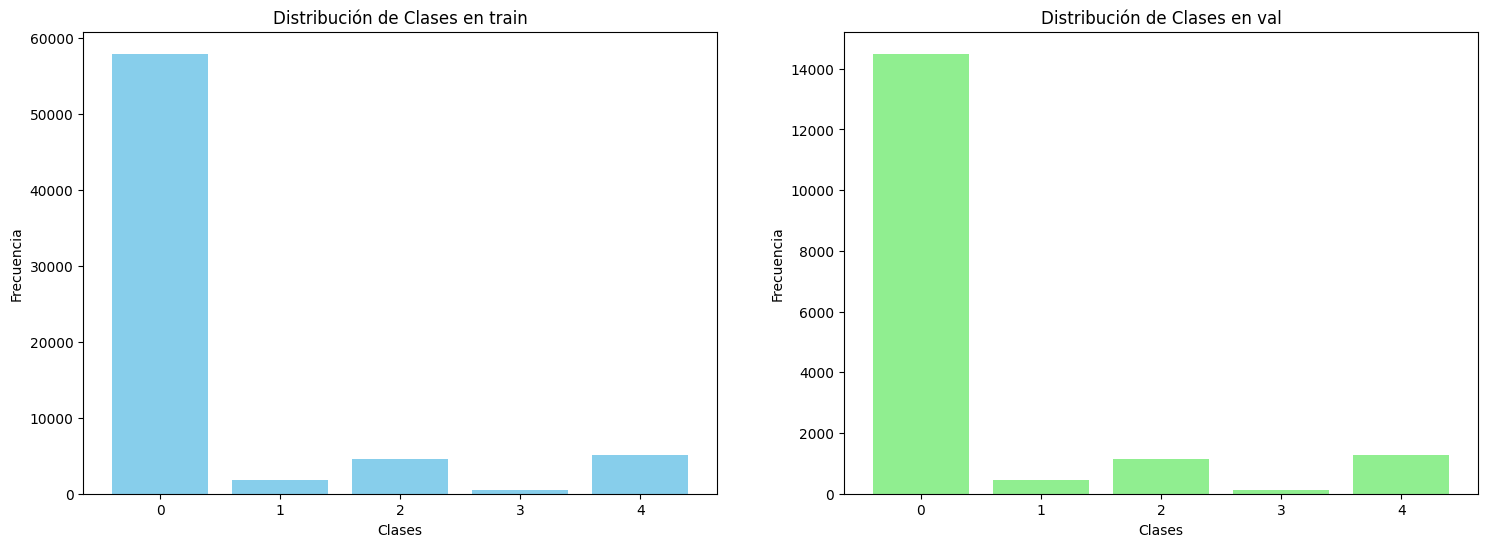

In [16]:
# Contar la frecuencia de cada clase en cada conjunto
class_counts_train = y_train.value_counts()
class_counts_val = y_val.value_counts()

# Crear subplots para los histogramas
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histograma para train
axes[0].bar(class_counts_train.index, class_counts_train.values, color="skyblue")
axes[0].set_title("Distribución de Clases en train")
axes[0].set_xlabel("Clases")
axes[0].set_ylabel("Frecuencia")

# Histograma para val
axes[1].bar(class_counts_val.index, class_counts_val.values, color="lightgreen")
axes[1].set_title("Distribución de Clases en val")
axes[1].set_xlabel("Clases")
axes[1].set_ylabel("Frecuencia")

plt.show()

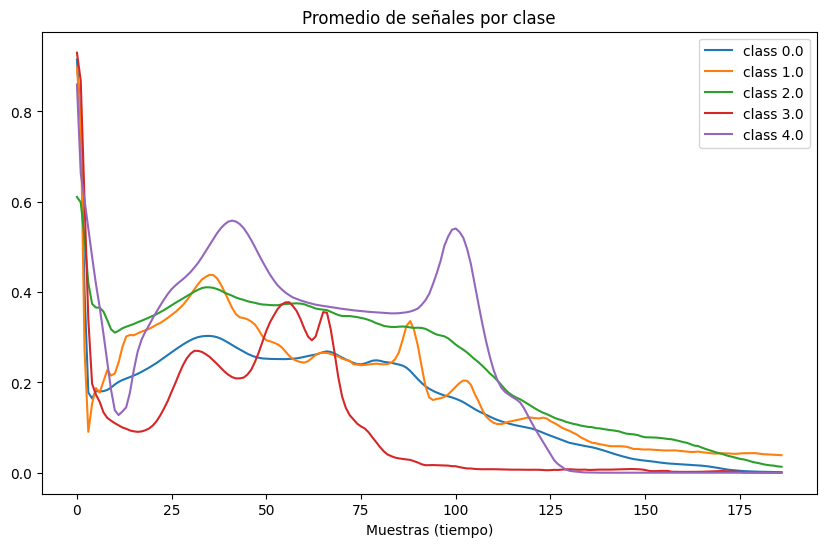

In [17]:
plt.figure(figsize=(10,6))
classes_to_plot = [0.0,1.0,2.0,3.0,4.0]

# Combine X_train and y_train for easier grouping
train_combined = X_train.copy()
train_combined['target'] = y_train

for c in classes_to_plot:
    # Select samples for the current class and calculate the mean
    average_sample = train_combined[train_combined['target'] == c].iloc[:, :-1].mean(axis=0)
    plt.plot(average_sample, label=f'class {c}')

plt.legend()
plt.title('Promedio de señales por clase')
plt.xlabel('Muestras (tiempo)')
plt.show()

In [18]:
nclasses = y_train.unique().shape[0]
print(f"Hay {nclasses} clases")

Hay 5 clases


In [19]:
train_dataset = MITBIHDataSet(X_train, y_train, nclasses)
val_dataset = MITBIHDataSet(X_val, y_val, nclasses)
test_dataset = MITBIHDataSet(X_test, y_test, nclasses)

In [32]:
def get_data_loaders(batch_size):

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    return train_loader, val_loader, test_loader

In [33]:
train_loader, val_loader, test_loader = get_data_loaders(
    BATCH_SIZE
)

In [70]:
class ECG_RNN(nn.Module):
    def __init__(self,input_size=1, hidden_size=64, num_classes=5,num_layers=2,dropout=0.3):
        super(ECG_RNN,self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        out, _ = self.rnn(x) # Capas, B, HIDDEN_DIM
        last = out[:, -1, :]
        return self.fc(last)

model_rnn = ECG_RNN().to(DEVICE)



In [71]:
optimizer_1 = optim.Adam(model_rnn.parameters(), lr=0.001)
criterion_1 = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [72]:
train_errors_rnn, val_errors_rnn = utils.train(model_rnn,optimizer_1,criterion_1,train_loader,val_loader,DEVICE,epochs=50,patience = 10)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 001 | Train Loss: 1.60015 | Val Loss: 1.58633
Epoch: 002 | Train Loss: 1.58563 | Val Loss: 1.59607
Epoch: 003 | Train Loss: 1.57552 | Val Loss: 1.57231
Epoch: 004 | Train Loss: 1.57816 | Val Loss: 1.58152
Epoch: 005 | Train Loss: 1.57707 | Val Loss: 1.58152
Epoch: 006 | Train Loss: 1.57739 | Val Loss: 1.58447
Epoch: 007 | Train Loss: 1.57756 | Val Loss: 1.57231
Epoch: 008 | Train Loss: 1.57690 | Val Loss: 1.57513
Epoch: 009 | Train Loss: 1.57779 | Val Loss: 1.57831
Epoch: 010 | Train Loss: 1.57890 | Val Loss: 1.57542
Epoch: 011 | Train Loss: 1.57699 | Val Loss: 1.57947
Epoch: 012 | Train Loss: 1.57631 | Val Loss: 1.58002
Epoch: 013 | Train Loss: 1.57659 | Val Loss: 1.57832
Detener entrenamiento en la época 12, la mejor pérdida fue 1.57231


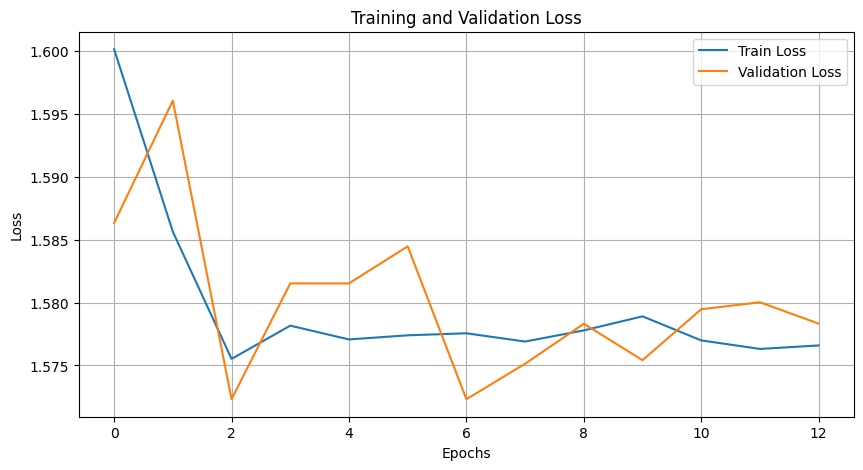

Accuracy: 0.8239

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90     18118
           1       0.29      0.11      0.16       556
           2       0.33      0.03      0.06      1448
           3       0.00      0.00      0.00       162
           4       0.00      0.00      0.00      1608

    accuracy                           0.82     21892
   macro avg       0.29      0.23      0.22     21892
weighted avg       0.72      0.82      0.76     21892



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [73]:
utils.plot_taining(train_errors_rnn, val_errors_rnn)
utils.model_calassification_report(model_rnn, test_loader, DEVICE, nclasses)

In [84]:
class ECG_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, num_classes=5, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        out, (h, c) = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

model_lstm = ECG_LSTM().to(DEVICE)

In [85]:
optimizer_2 = optim.Adam(model_lstm.parameters(), lr=0.001)
criterion_2 = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [86]:
train_errors_lstm, val_errors_lstm = utils.train(model_lstm,optimizer_2,criterion_2,train_loader,val_loader,DEVICE,epochs=100,patience = 10)

Epoch: 001 | Train Loss: 1.58772 | Val Loss: 1.55636
Epoch: 002 | Train Loss: 1.51748 | Val Loss: 1.84617
Epoch: 003 | Train Loss: 1.29668 | Val Loss: 1.31071
Epoch: 004 | Train Loss: 1.21209 | Val Loss: 1.17503
Epoch: 005 | Train Loss: 1.17537 | Val Loss: 1.11854
Epoch: 006 | Train Loss: 1.14973 | Val Loss: 1.11869
Epoch: 007 | Train Loss: 1.13510 | Val Loss: 1.09191
Epoch: 008 | Train Loss: 1.10842 | Val Loss: 1.07405
Epoch: 009 | Train Loss: 1.10696 | Val Loss: 1.07621
Epoch: 010 | Train Loss: 1.08711 | Val Loss: 1.03305
Epoch: 011 | Train Loss: 1.06928 | Val Loss: 1.28594
Epoch: 012 | Train Loss: 1.08368 | Val Loss: 0.97355
Epoch: 013 | Train Loss: 0.99544 | Val Loss: 0.95968
Epoch: 014 | Train Loss: 0.95512 | Val Loss: 0.87832
Epoch: 015 | Train Loss: 0.93132 | Val Loss: 0.88467
Epoch: 016 | Train Loss: 0.86429 | Val Loss: 0.78088
Epoch: 017 | Train Loss: 0.81821 | Val Loss: 0.87470
Epoch: 018 | Train Loss: 0.84512 | Val Loss: 0.74358
Epoch: 019 | Train Loss: 0.75954 | Val Loss: 0

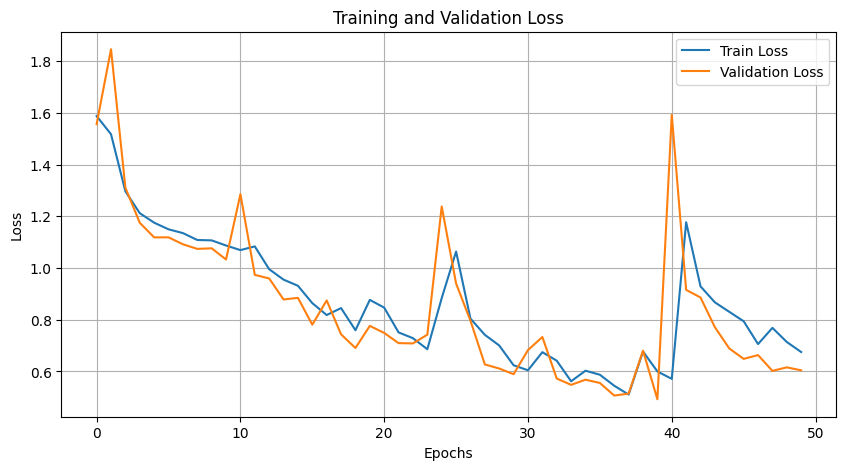

Accuracy: 0.6650

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      0.64      0.77     18118
           1       0.13      0.69      0.21       556
           2       0.34      0.82      0.48      1448
           3       0.07      0.83      0.14       162
           4       0.77      0.83      0.80      1608

    accuracy                           0.67     21892
   macro avg       0.46      0.76      0.48     21892
weighted avg       0.89      0.67      0.73     21892



In [87]:
utils.plot_taining(train_errors_lstm, val_errors_lstm)
utils.model_calassification_report(model_lstm, test_loader, DEVICE, nclasses)

In [88]:
class ECG_GRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, num_classes=5, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        out, h = self.gru(x)
        last = out[:, -1, :]
        return self.fc(last)


model_gru = ECG_GRU().to(DEVICE)


In [89]:
optimizer_3 = optim.Adam(model_gru.parameters(), lr=0.001)
criterion_3 = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [90]:
train_errors_gru, val_errors_gru = utils.train(model_gru,optimizer_3,criterion_3,train_loader,val_loader,DEVICE,epochs=100,patience = 10)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 001 | Train Loss: 1.58549 | Val Loss: 1.55189
Epoch: 002 | Train Loss: 1.44819 | Val Loss: 1.24690
Epoch: 003 | Train Loss: 1.22039 | Val Loss: 1.17163
Epoch: 004 | Train Loss: 1.18194 | Val Loss: 1.17277
Epoch: 005 | Train Loss: 1.15095 | Val Loss: 1.09902
Epoch: 006 | Train Loss: 1.12474 | Val Loss: 1.06976
Epoch: 007 | Train Loss: 1.08907 | Val Loss: 1.06713
Epoch: 008 | Train Loss: 1.09948 | Val Loss: 1.02453
Epoch: 009 | Train Loss: 0.98978 | Val Loss: 0.89320
Epoch: 010 | Train Loss: 0.86019 | Val Loss: 0.76135
Epoch: 011 | Train Loss: 0.76378 | Val Loss: 0.71937
Epoch: 012 | Train Loss: 0.69508 | Val Loss: 0.63398
Epoch: 013 | Train Loss: 0.62756 | Val Loss: 0.58864
Epoch: 014 | Train Loss: 0.58923 | Val Loss: 0.57034
Epoch: 015 | Train Loss: 0.55498 | Val Loss: 0.51517
Epoch: 016 | Train Loss: 0.52519 | Val Loss: 0.63472
Epoch: 017 | Train Loss: 0.49884 | Val Loss: 0.51494
Epoch: 018 | Train Loss: 0.49574 | Val Loss: 0.45372
Epoch: 019 | Train Loss: 0.46135 | Val Loss: 0

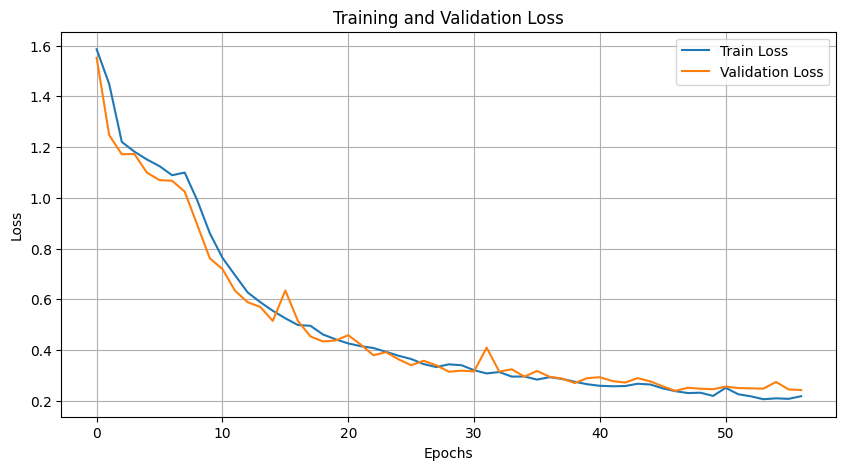

Accuracy: 0.8589

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     18118
           1       0.26      0.84      0.39       556
           2       0.76      0.94      0.84      1448
           3       0.12      0.92      0.22       162
           4       0.90      0.97      0.94      1608

    accuracy                           0.86     21892
   macro avg       0.61      0.90      0.66     21892
weighted avg       0.95      0.86      0.89     21892



In [91]:
utils.plot_taining(train_errors_gru, val_errors_gru)
utils.model_calassification_report(model_gru, test_loader, DEVICE, nclasses)

In [92]:
import wandb

In [93]:
WANDB_TEAM_NAME = "joacoguerrae-ort"
WANDB_PROJECT = "[wandb-labo2-guerra-sanes]"
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: joacoguerrae (joacoguerrae-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True